# <center>**PROYECTO FINAL INTERCONNECT (2da parte)**</center>

## Código de solución

### Continuación del plan de trabajo

3. Preprocesamiento de datos: 
    * Conversión de variables categóricas en dummies 
    * manejo de desequilibrio de clases 
    * Selección de características: Aplicación de técnicas de filtrado y envoltura para reducir la dimensionalidad y seleccionar características relevantes.
4. Selección y entrenamiento de modelos: division de sets para entrenamiento y prueba, probar algoritmos de clasificación.
5. Evaluación y optimización del modelo: Evaluación de los modelos con metricas apropiadas, optimización de hiperparámetros y selección del modelo

In [2]:
# Asignción de librerías.
import pandas as pd
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

In [2]:
# Asignacion del DataFrame realizado en la parte 1 del proyecto.
df_intercon = pd.read_csv(r'datasets\df_intercon.csv')
df_intercon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   int64  
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movies   7043 

In [3]:
# Creación de dummies para características categóricas

# División de columnas en numéricas y categóricas
# Seleccionar columnas categóricas
cat_columns = df_intercon.drop(
    columns=['customer_id', 'monthly_charges', 'total_charges', 'churn']).columns

# Crear variables dummy
categorical_columns_df = pd.get_dummies(
    df_intercon[cat_columns], drop_first=True)

numerical_columns = df_intercon[['monthly_charges', 'total_charges', 'churn']]

# Combinar variables dummy con columnas numéricas
df_final = pd.concat([categorical_columns_df, numerical_columns], axis=1)


# Verificar las columnas finales del DataFrame
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   senior_citizen                          7043 non-null   int64  
 1   type_One year                           7043 non-null   bool   
 2   type_Two year                           7043 non-null   bool   
 3   paperless_billing_Yes                   7043 non-null   bool   
 4   payment_method_Credit card (automatic)  7043 non-null   bool   
 5   payment_method_Electronic check         7043 non-null   bool   
 6   payment_method_Mailed check             7043 non-null   bool   
 7   gender_Male                             7043 non-null   bool   
 8   partner_Yes                             7043 non-null   bool   
 9   dependents_Yes                          7043 non-null   bool   
 10  internet_service_Fiber optic            7043 non-null   bool

In [4]:
# Desequilibrio de clases.

# Para este paso dividire el dataframe en features y target para poder aplicar SMOTE de la libreria imbalanced-learned.add()
# Lo que hará, será sobremuestrar la clase minoría que como vimos en la parte 1 del proyecto abarcaba casi la 3er parte del total.

features = df_final.drop(columns=['churn'])
target = df_final['churn']

smote = SMOTE(random_state=24680)
features_r, target_r = smote.fit_resample(features, target)

# Combinar features y targes en un solo dataframe
df_resampled = pd.DataFrame(features_r, columns=features.columns)
df_resampled['churn'] = target_r.reset_index(drop=True)

# Mezclado de caracteristicas y objetivo para eficientar modelos y evitar que detecte patrones inecesarios.
df_final2 = shuffle(df_resampled, random_state=24680)

print(df_resampled['churn'].value_counts())

churn
0    5174
1    5174
Name: count, dtype: int64


### Selección de características

En este apartado, para la selección de características se aplicarán dos metodos:

1. Método de filtrado: Aquí detectaremos todas aquellas que tengan una alta correlación entre sí y eliminar una de ellas, así evitaremos la multicolinealidad y la redundancia en la información, creando modelos mas compactos y certeros.
    
2. Método de wrapping con randomforest: En esta parte, tomamos un método de las librerias de sklearn para seleccionar 15 de las características mas relevantes de nuestro dataframe.

Al analizar estos dos métodos de selección de características, obtendremos dos dataframes con los que estaremos trabajando mas adelante en nuestros modelos. Uno corresponderá a la union de ambas listas obtenidas por los métodos de filtrado y wrapping y la otra sera la intersección de éstas. 
Con esto Aseguraremos que nuestro modelo obtenido sea el mas óptimo y de mayor calidad.

### Filtrado:

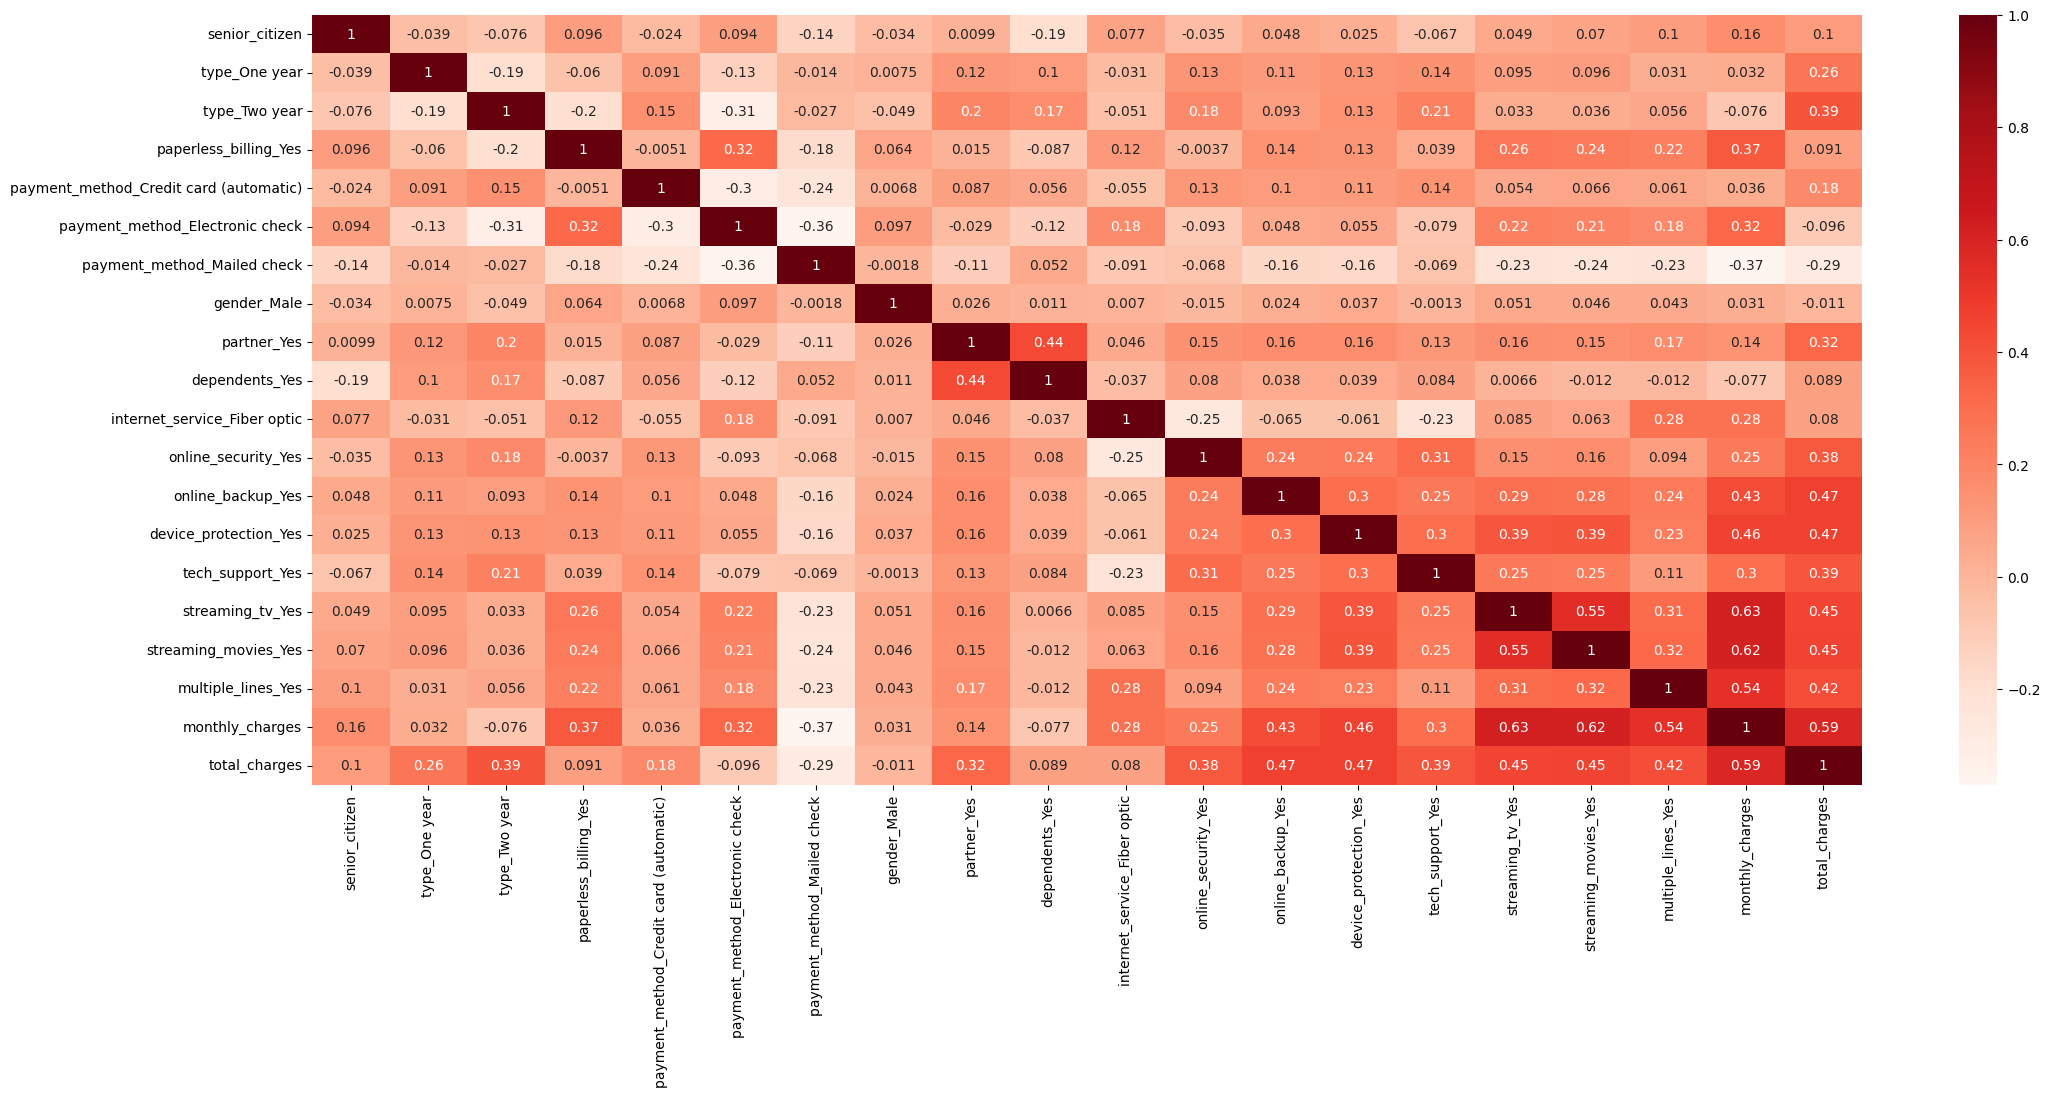

Características seleccionadas por SelectKBest:
Index(['type_One year', 'type_Two year', 'paperless_billing_Yes',
       'payment_method_Electronic check', 'gender_Male', 'dependents_Yes',
       'internet_service_Fiber optic', 'online_security_Yes',
       'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_Yes',
       'monthly_charges', 'total_charges'],
      dtype='object')


In [5]:
# Dividir en características (X) y variable objetivo (y)
features = df_final2.drop(columns=['churn'])
target = df_final2['churn']

# Filtrado - Eliminación de características altamente correlacionadas
correlation_matrix = features.corr()
plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

# Eliminación de características con alta correlación
threshold = 0.8
high_corr_var = np.where(np.abs(correlation_matrix) > threshold)
high_corr_var = [(correlation_matrix.columns[x], correlation_matrix.columns[y])
                 for x, y in zip(*high_corr_var) if x != y and x < y]

# Eliminación de características altamente correlacionadas
for x, y in high_corr_var:
    features = features.drop(columns=[y])

# Filtramos con la selección de características de SelectKBest
select_k_best = SelectKBest(chi2, k=13)
select_k_best.fit(features, target)

# Obtenemos las características seleccionadas
kbest_features = features.columns[select_k_best.get_support()]

print("Características seleccionadas por SelectKBest:")
print(kbest_features)

### Wrapping:

In [6]:
# Usaremos los datos que obtuvimos tras eliminar aquellos con una correlación mayor a 0.8

# Wrapping RFE con RandomForestClassifier
model = RandomForestClassifier(random_state=24680)
rfe = RFE(estimator=model, n_features_to_select=13)
features_rfe = rfe.fit_transform(features, target)

# Obtener las características seleccionadas por RFE
rfe_features = features.columns[rfe.support_]

print("Características seleccionadas por RFE:")
print(rfe_features)

Características seleccionadas por RFE:
Index(['type_One year', 'type_Two year', 'paperless_billing_Yes',
       'payment_method_Electronic check', 'gender_Male', 'partner_Yes',
       'internet_service_Fiber optic', 'online_backup_Yes', 'streaming_tv_Yes',
       'streaming_movies_Yes', 'multiple_lines_Yes', 'monthly_charges',
       'total_charges'],
      dtype='object')


In [7]:
# Intersección de características de ambos métodos

intersect_features = list(set(kbest_features) & set(rfe_features))
print("Intersección de características seleccionadas por ambos métodos:")
print(intersect_features)

# Unión de características seleccionadas por ambos métodos
union_features = list(set(kbest_features) | set(rfe_features))
print("Unión de características seleccionadas por ambos métodos:")
print(union_features)

Intersección de características seleccionadas por ambos métodos:
['type_Two year', 'multiple_lines_Yes', 'gender_Male', 'payment_method_Electronic check', 'total_charges', 'internet_service_Fiber optic', 'type_One year', 'streaming_tv_Yes', 'monthly_charges', 'streaming_movies_Yes', 'paperless_billing_Yes']
Unión de características seleccionadas por ambos métodos:
['type_Two year', 'multiple_lines_Yes', 'payment_method_Electronic check', 'total_charges', 'internet_service_Fiber optic', 'streaming_tv_Yes', 'online_backup_Yes', 'partner_Yes', 'monthly_charges', 'streaming_movies_Yes', 'online_security_Yes', 'gender_Male', 'dependents_Yes', 'type_One year', 'paperless_billing_Yes']


In [8]:
# Creación de DataFrames con características seleccionadas
df_intersected = df_final2[intersect_features + ['churn']]
df_union = df_final2[union_features + ['churn']]

print("Información del DataFrame con intersección de características:")
print(df_intersected.info())

Información del DataFrame con intersección de características:
<class 'pandas.core.frame.DataFrame'>
Index: 10348 entries, 5914 to 8294
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   type_Two year                    10348 non-null  bool   
 1   multiple_lines_Yes               10348 non-null  bool   
 2   gender_Male                      10348 non-null  bool   
 3   payment_method_Electronic check  10348 non-null  bool   
 4   total_charges                    10348 non-null  float64
 5   internet_service_Fiber optic     10348 non-null  bool   
 6   type_One year                    10348 non-null  bool   
 7   streaming_tv_Yes                 10348 non-null  bool   
 8   monthly_charges                  10348 non-null  float64
 9   streaming_movies_Yes             10348 non-null  bool   
 10  paperless_billing_Yes            10348 non-null  bool   
 11  churn               

In [9]:
print("Información del DataFrame con unión de características:")
print(df_union.info())

Información del DataFrame con unión de características:
<class 'pandas.core.frame.DataFrame'>
Index: 10348 entries, 5914 to 8294
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   type_Two year                    10348 non-null  bool   
 1   multiple_lines_Yes               10348 non-null  bool   
 2   payment_method_Electronic check  10348 non-null  bool   
 3   total_charges                    10348 non-null  float64
 4   internet_service_Fiber optic     10348 non-null  bool   
 5   streaming_tv_Yes                 10348 non-null  bool   
 6   online_backup_Yes                10348 non-null  bool   
 7   partner_Yes                      10348 non-null  bool   
 8   monthly_charges                  10348 non-null  float64
 9   streaming_movies_Yes             10348 non-null  bool   
 10  online_security_Yes              10348 non-null  bool   
 11  gender_Male                

In [10]:
# Funcion para la division de dataframes en entrenamiento y prueba:
def div_test(df):
    x = df.drop(columns=['churn'])
    y = df['churn']
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.30, random_state=12345)

    return x_train, x_test, y_train, y_test

In [11]:

# Función para entrenamiento y evaluación de modelos
def evaluate_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)

    # Predicciones
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    # Probabilidades de la clase positiva
    y_pred_proba_train = model.predict_proba(x_train)[:, 1]
    y_pred_proba_test = model.predict_proba(x_test)[:, 1]

    # Calcular AUC ROC
    auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
    auc_roc_test = roc_auc_score(y_test, y_pred_proba_test)
    print(f"AUC ROC (entrenamiento): {auc_roc_train:.4f}")
    print(f"AUC ROC (prueba): {auc_roc_test:.4f}")

    # Matriz de confusión
    print("Confusion Matrix (prueba):")
    print(confusion_matrix(y_test, y_pred_test))

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision
    precision = precision_score(y_test, y_pred_test)
    print(f"Precision: {precision:.4f}")

    # F1-score
    f1 = f1_score(y_test, y_pred_test)
    print(f"F1-score: {f1:.4f}")

    # Calcular la curva ROC para el conjunto de entrenamiento
    fpr_train, tpr_train, _train = roc_curve(y_train, y_pred_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Calcular la curva ROC para el conjunto de prueba
    fpr_test, tpr_test, _test = roc_curve(y_test, y_pred_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='blue', lw=2,
             label=f'ROC curve (entrenamiento) (area = {roc_auc_train:.4f})')
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2,
             label=f'ROC curve (prueba) (area = {roc_auc_test:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

    return

In [12]:

# Función creada para comprobar que no exista un sobreajuste en los modelos entrenados con validacion cruzada

def evaluate_model_with_cv(model, x_test, y_test, cv=10):
    # Validación cruzada en el conjunto de entrenamiento
    scores = cross_val_score(model, x_test, y_test, cv=cv, scoring='roc_auc')
    print(f"AUC ROC promedio en validación cruzada: {
          scores.mean():.4f} +/- {scores.std():.4f}")

    return

In [13]:
# Asignación de sets de entrenamiento y prueba para la unión de características
x_train, x_test, y_train, y_test = div_test(df_union)

# Asignación de sets de entrenamiento y prueba para la intersección de características

x_trainI, x_testI, y_trainI, y_testI = div_test(df_intersected)

### Modelo base: DummyClassifier

AUC ROC (entrenamiento): 0.5000
AUC ROC (prueba): 0.5000
Confusion Matrix (prueba):
[[   0 1525]
 [   0 1580]]
Accuracy: 0.5089
Precision: 0.5089
F1-score: 0.6745


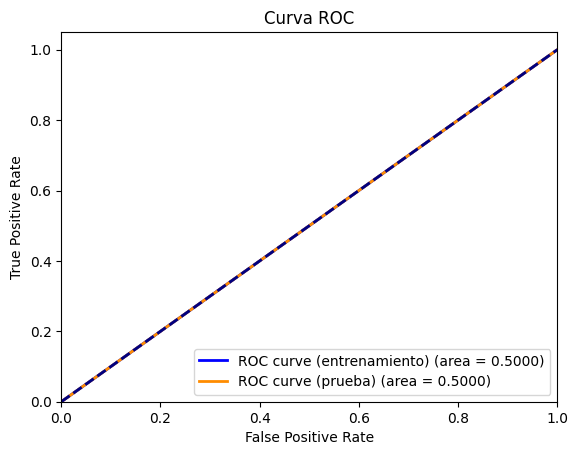

In [14]:
model_0 = DummyClassifier(strategy='constant', constant=1)
evaluate_model(model_0, x_train, x_test, y_train, y_test)

### Modelo de Regresión Logística
- Primer iteración con unión de características 

In [15]:
model_rl = LogisticRegression(max_iter=1000, random_state=1234)

AUC ROC (entrenamiento): 0.8653
AUC ROC (prueba): 0.8690
Confusion Matrix (prueba):
[[1176  349]
 [ 322 1258]]
Accuracy: 0.7839
Precision: 0.7828
F1-score: 0.7895


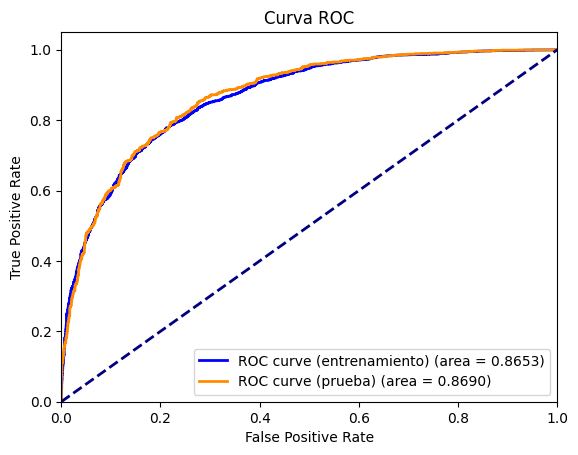

AUC ROC promedio en validación cruzada: 0.8687 +/- 0.0161


In [16]:
# 1er iteración con el dataframe df_intersected.
evaluate_model(model_rl, x_train, x_test, y_train, y_test)

# Prueba cruzada con el modelo de regresión logística
evaluate_model_with_cv(model_rl, x_test, y_test)

- Segunda iteración con características intersectadas

AUC ROC (entrenamiento): 0.8635
AUC ROC (prueba): 0.8692
Confusion Matrix (prueba):
[[1186  339]
 [ 324 1256]]
Accuracy: 0.7865
Precision: 0.7875
F1-score: 0.7912


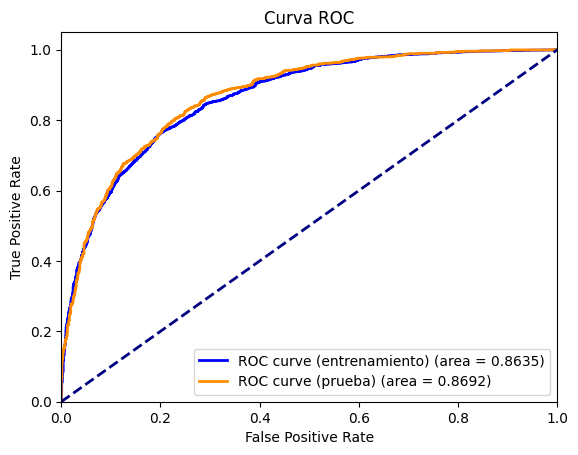

AUC ROC promedio en validación cruzada: 0.8686 +/- 0.0153


In [17]:
# 2da iteración con el dataframe df_intersected.
evaluate_model(model_rl, x_trainI, x_testI, y_trainI, y_testI)

# Prueba cruzada con el modelo de regresión logística
evaluate_model_with_cv(model_rl, x_testI, y_testI)

# <center>**Modelado**</center>

### Modelo de Random Forest
- Primer iteración con unión de características 

AUC ROC (entrenamiento): 0.9907
AUC ROC (prueba): 0.9199
Confusion Matrix (prueba):
[[1266  259]
 [ 235 1345]]
Accuracy: 0.8409
Precision: 0.8385
F1-score: 0.8448


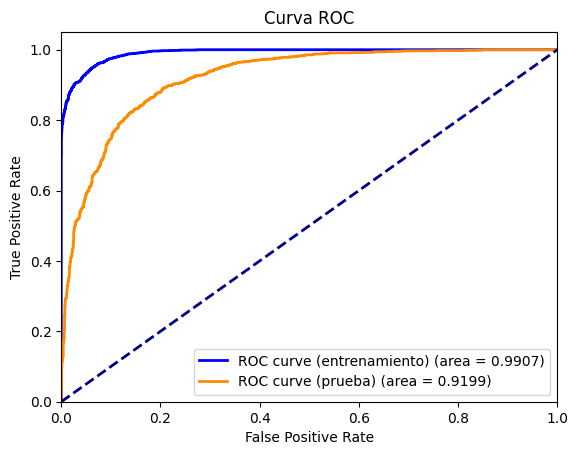

AUC ROC promedio en validación cruzada: 0.9051 +/- 0.0147


In [18]:
model_rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=3,  min_samples_leaf=2, random_state=1234)

evaluate_model(model_rf, x_train, x_test, y_train, y_test)

# Prueba cruzada con el modelo de regresión logística
evaluate_model_with_cv(model_rf, x_test, y_test)

- Segunda iteración con características intersectadas

AUC ROC (entrenamiento): 0.9916
AUC ROC (prueba): 0.9148
Confusion Matrix (prueba):
[[1260  265]
 [ 241 1339]]
Accuracy: 0.8370
Precision: 0.8348
F1-score: 0.8411


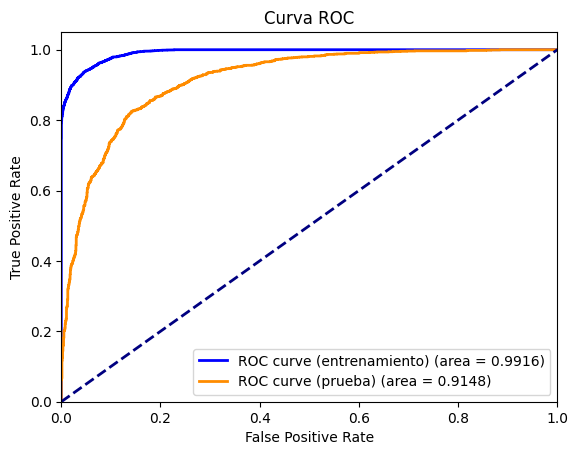

AUC ROC promedio en validación cruzada: 0.9027 +/- 0.0155


In [19]:

evaluate_model(model_rf, x_trainI, x_testI, y_trainI, y_testI)
evaluate_model_with_cv(model_rf, x_testI, y_testI)

### Modelo de Gradient Boosting
- Primer iteración con unión de características 

AUC ROC (entrenamiento): 0.9288
AUC ROC (prueba): 0.9143
Confusion Matrix (prueba):
[[1232  293]
 [ 233 1347]]
Accuracy: 0.8306
Precision: 0.8213
F1-score: 0.8366


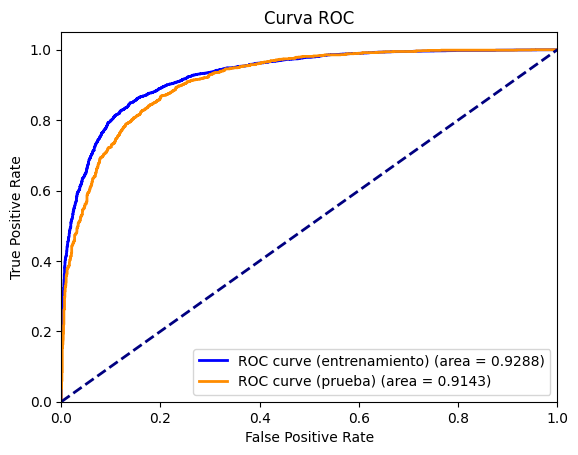

AUC ROC promedio en validación cruzada: 0.9012 +/- 0.0109


In [20]:
model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=2,
                                      min_samples_split=3, min_samples_leaf=2, subsample=1, random_state=1234)

evaluate_model(model_gb, x_train, x_test, y_train, y_test)
evaluate_model_with_cv(model_gb, x_test, y_test)

- Segunda iteración con características intersectadas

AUC ROC (entrenamiento): 0.9262
AUC ROC (prueba): 0.9112
Confusion Matrix (prueba):
[[1228  297]
 [ 228 1352]]
Accuracy: 0.8309
Precision: 0.8199
F1-score: 0.8374


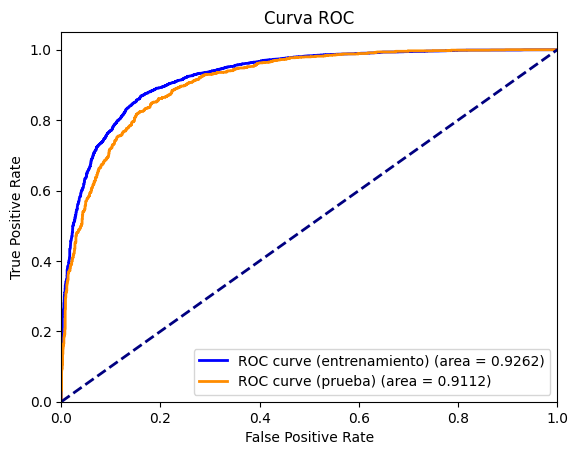

AUC ROC promedio en validación cruzada: 0.8998 +/- 0.0132


In [21]:
evaluate_model(model_gb, x_trainI, x_testI, y_trainI, y_testI)
evaluate_model_with_cv(model_gb, x_testI, y_testI)

### Modelo de K-Nearest Neighbors (KNN)
- Primer iteración con unión de características 

AUC ROC (entrenamiento): 0.9286
AUC ROC (prueba): 0.8330
Confusion Matrix (prueba):
[[1093  432]
 [ 303 1277]]
Accuracy: 0.7633
Precision: 0.7472
F1-score: 0.7765


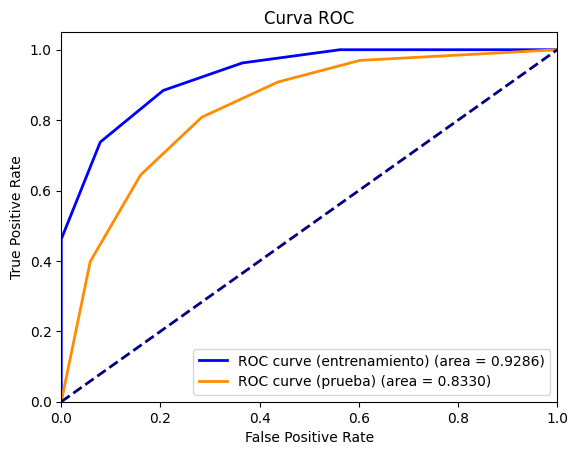

AUC ROC promedio en validación cruzada: 0.7894 +/- 0.0173


In [22]:
model_knn = KNeighborsClassifier()
evaluate_model(model_knn, x_train, x_test, y_train, y_test)
evaluate_model_with_cv(model_knn, x_test, y_test)

- Segunda iteración con características intersectadas

AUC ROC (entrenamiento): 0.9285
AUC ROC (prueba): 0.8344
Confusion Matrix (prueba):
[[1101  424]
 [ 301 1279]]
Accuracy: 0.7665
Precision: 0.7510
F1-score: 0.7792


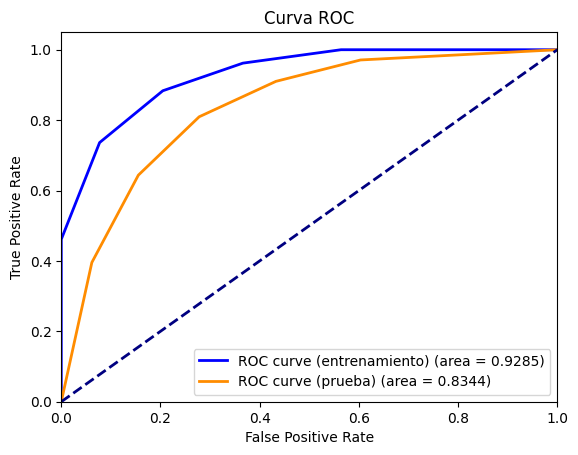

AUC ROC promedio en validación cruzada: 0.7894 +/- 0.0177


In [23]:
evaluate_model(model_knn, x_trainI, x_testI, y_trainI, y_testI)
evaluate_model_with_cv(model_knn, x_testI, y_testI)

### Modelo de CatBoost Classifier
- Primer iteración con unión de características 

AUC ROC (entrenamiento): 0.9810
AUC ROC (prueba): 0.9239
Confusion Matrix (prueba):
[[1266  259]
 [ 223 1357]]
Accuracy: 0.8448
Precision: 0.8397
F1-score: 0.8492


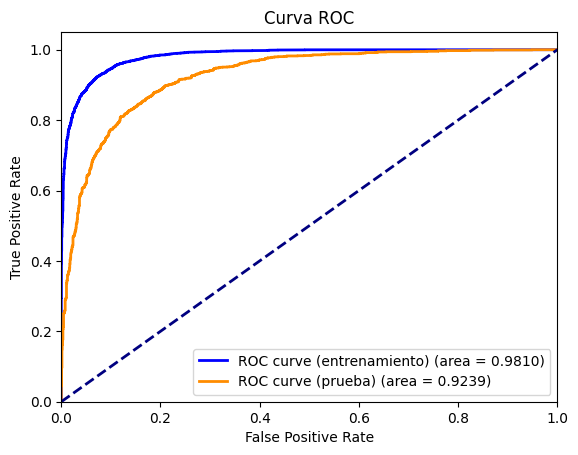

AUC ROC promedio en validación cruzada: 0.9071 +/- 0.0130


In [24]:
model_catboost = CatBoostClassifier(
    iterations=1300, learning_rate=0.04, depth=6, l2_leaf_reg=4, random_state=1234, verbose=0)
evaluate_model(model_catboost, x_train, x_test, y_train, y_test)
evaluate_model_with_cv(model_catboost, x_test, y_test)

- Segunda iteración con características intersectadas

AUC ROC (entrenamiento): 0.9720
AUC ROC (prueba): 0.9189
Confusion Matrix (prueba):
[[1263  262]
 [ 226 1354]]
Accuracy: 0.8428
Precision: 0.8379
F1-score: 0.8473


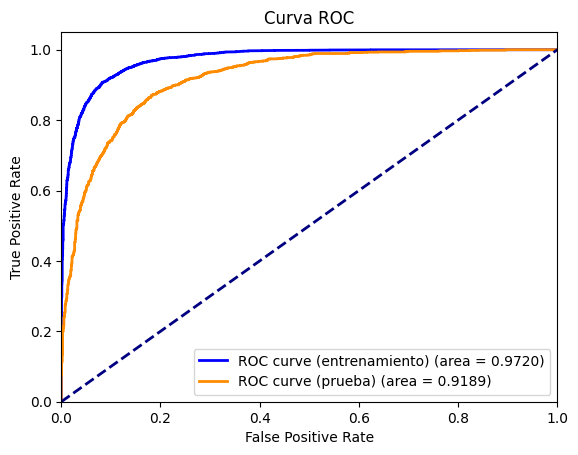

AUC ROC promedio en validación cruzada: 0.9018 +/- 0.0169


In [25]:
evaluate_model(model_catboost, x_trainI, x_testI, y_trainI, y_testI)
evaluate_model_with_cv(model_catboost, x_testI, y_testI)

## Informe de selección de modelo

Durante la elaboración de la segunda parte del proyecto, se trabajaron varios métodos para la obtención de las características claves del entrenamiento del modelo. 

Mediante filtrado y wrapping se obtuvieron dos diferentes dataframes, los cuales fueron utilizados en el entrenamiento de los modelos para determinar cual entregó mejores resultados:
* df_union: Unión entre las dos listas obtenidas.
* df_intersected: Intersección de ambas listas obtenidas

Para la determinación del mejor algoritmo de clasificación, se hicieron varias pruebas con diferentes hiperparámetros y las mejores combinaciones fueron las que quedaron dentro de la llamada de la función. 

A continuación se muestra una tabla comparativa con las iteraciones de los modelos que mejores resultados dieron, partiendo de uno base hacia otros mas robustos.

| Modelo         | DF utilizado | Accuracy | Precision | F1-Score | AUC-ROC Entrenamiento | AUC-ROC Prueba | AUC-ROC Validacion Cruzada|
|:--------------:|:------------:|:--------:|:---------:|:--------:|:---------------------:|:--------------:|:-------------------------:|
|Dummy Classifier|df_union      |0.5089    |0.5089     |0.6745    |0.5                    |0.5             |None                       |
|LogisticRegression|df_union    |0.7839    |0.7828     |0.7895    |0.8653                 |0.8690          |0.8687                     |
|LogisticRegression|df_intersected|0.7865  |0.7875     |0.7912    |0.8635                 |0.8692          |0.8686                     |
|RandomForestClassifier|df_union    |0.8409|0.8385     |0.8448    |0.9907                 |0.9199          |0.9051                     |
|RandomForestClassifier|df_intersected|0.8370|0.8348   |0.8411    |0.9916                 |0.9148          |0.9027                     |
|GradientBoostingClassifier|df_union|0.8306|0.8213     |0.8366    |0.9288                 |0.9143          |0.9012                     |
|GradientBoostingClassifier|df_intersected|0.8309|0.8199|0.8374   |0.9262                 |0.9112          |0.8998                     |
|KNeighborsClassifier|df_union  |0.7633    |0.7472     |0.7765    |0.9286                 |0.8330          |0.7894                     |
|KNeighborsClassifier|df_intersected|0.7665|0.7510     |0.7792    |0.9285                 |0.8344          |0.7894                     |
|CatBoostClassifier|df_union    |0.8448    |0.8397     |0.8492    |0.9810                 |0.9239          |0.9071                     |
|CatBoostClassifier|df_intersected|0.8428  |0.8379     |0.8473    |0.9720                 |0.9189          |0.9018                     |


Con esta comparativa podemos decir que:
- De todos los modelos entrenados la mejor opción al momento de la selección de características, fue la unión resultante de éstas con los métodos de filtrado y wrapping. 
- El mejor modelo para la detección de fuga fue el CatBoostClassifier, cumpliendo e incluso sobrepasando el puntaje mayor para la aprobación del proyecto, ya que en prueba dió 0.9239 y el promedio de las validaciones cruzadas: 0.9071. Incluso las demás medidas como accuracy, precision y f1 fueron muy superiores al resto. Cabe mencionar también que el segundo mejor fue el RandomForest, quedandose atrás por una diferencia muy pequeña; Así que ambos son selecciones muy buenas para implementar como algoritmo de predicción. 